In [1]:
import pandas as pd
import cptac
import cptac.pancan as pc
import scipy.stats
import seaborn as sns

import plot_utils as p
import cptac.utils as ut

cptac warning: Your version of cptac (0.9.3) is out-of-date. Latest is 0.9.4. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-afdc2a284a10>, line 2)


In [2]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [3]:
def get_corr(df, dup_list):
    
    
    new = pd.DataFrame()
    
    for i in dup_list:
        ids = df.columns[df.columns.str.contains(i)].to_list()
        ids.remove(i+'_flagship')
        flag = i+'_flagship'
        
        for  ali in ids:
            test_df = both[[flag, ali]].dropna() # only plots if value for both flagship and panan
            # Create df with correlations
            first = p.wrap_pearson_corr(test_df, flag)
            new = new.append(first)
    return new

In [4]:
# correlation analysis: compares flagship values to duplicates in pancan
# df is df with both flagship and pancan values (flagship marked as '_flagship')
# dup_list is list of Patient IDs (without aliquots attached)
# y_lab is which source 

def wrap_lin_reg(df, dup_list, y_lab, wa = True):
    for i in dup_list:
        if wa == True:
            if '.N' in i:
                ids = df.columns[df.columns.str.contains(i)].to_list()
            else:
                ids = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('\.N')].to_list()
            ids.remove(i+'_flagship')
            flag = i+'_flagship'
        else:
            flag = i+'_flagship'
            ids = [i, i+'_1']           

        for first in ids:
            plot_df = both[[flag, first]].dropna(axis = 'index', how = 'any')
            xd = plot_df[flag].min() + ((plot_df[flag].max() - plot_df[flag].min()) / 3) 
            yd = plot_df[first].max() +1


            p.plot_pearson(plot_df, flag, first, x_coor = xd, y_coor = yd, y_label = first+'_pdc',
                   hue = "none", title = "", ra_stats = True,
                   show_plot = True)

In [5]:
def get_flag_df(omics_name, ca, dup_list):
    if omics_name == 'prot':
        df = ca.get_proteomics()
    
    elif omics_name == 'phospho':
        df = ca.get_phosphoproteomics()
        
    elif omics_name == 'acetyl':
        df = ca.get_acetylproteomics()
        
    if ca.get_cancer_type() == 'brca':
        df.index = [x[1:] if x[0] == 'X' else x for x in df.index]

    df = df.loc[df.index.isin(dup_list)]
    df.index = df.index+'_flagship'
    if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
        if omics_name == 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop = ['Database_ID'])
        else: # phospho and acetyl
            df = ut.reduce_multiindex(df, levels_to_drop = ['Peptide', 'Database_ID'], flatten = True)
        df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
    fdf = df.T
    
    if ca.get_cancer_type() == 'luad' and omics_name == 'phospho':
        # capitalize AA sites 
        fdf.index = fdf.index.str.upper()
    
    return fdf     

In [12]:
def get_pc_df(omics_name, ca_obj, source_name, dup_list = [], with_aliquots = True):
    if omics_name == 'prot':
        df = ca_obj.get_proteomics(source_name)
    
    elif omics_name == 'phospho':
        df = ca_obj.get_phosphoproteomics(source_name)
        
    elif omics_name == 'acetyl':
        df = ca_obj.get_acetylproteomics(source_name)
        
    
    if with_aliquots == False:
        df = df.loc[df.index.duplicated(keep = False)]
        if omics_name != 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop=[1], flatten = True)
        df = df.T
        df = df.drop(['aliquot_submitter_id', 'case_submitter_id'])
    
    # When using aliquots, pass in a list of patient_IDs
    else:
        df = df.reset_index()
        if omics_name != 'prot':
            df = ut.reduce_multiindex(df, levels_to_drop=[1], flatten = True)
            
        # brca wasn't mapped (no .N) so use case_submitter_id
        if ca_obj.get_cancer_type() == 'pancanbrca': 
            df = df.loc[df.case_submitter_id.isin(dup_list)] # test with 21BR010 -> only 1 aliquot but part of 18 IDs with normal
            to_drop = ['case_submitter_id', 'aliquot_submitter_id']
            
        # luad and hnscc were mapped so use Patient_ID
        else: 
            df = df.loc[df.Patient_ID.isin(dup_list)]
            to_drop = ['case_submitter_id', 'aliquot_submitter_id', 'Patient_ID']
        df.index = df.case_submitter_id+'_'+df.aliquot_submitter_id
        df = df.T
        df = df.drop(to_drop)
    
    df.index = df.index.str.upper()   
    df = rename_duplicate_cols(df)
        
    return df

# Brca

In [7]:
b = pc.PancanBrca()
brca = cptac.Brca(version='3.1.1')

cptac warning: Old brca data version. Latest is 5.4. This is 3.1.1. (<ipython-input-7-04548f4bd6d7>, line 2)


In [8]:
# show which omics has duplicates
ca = b
source_name = 'pdc'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
acetyl = ca.get_acetylproteomics(source_name)
print('prot:', set(prot.index.duplicated()), len(prot.index[prot.index.duplicated()]), 'duplicates')
print('phospho:', set(phos.index.duplicated()), len(phos.index[phos.index.duplicated()]), 'duplicates')
print('acetyl:', set(acetyl.index.duplicated()), len(acetyl.index[acetyl.index.duplicated()]), 'duplicates')

prot: {False} 0 duplicates
phospho: {False, True} 8 duplicates
acetyl: {False, True} 8 duplicates


In [9]:
# From prosp-brca-all-samples.txt
rep = ['11BR031', '11BR053', '11BR036', '11BR060', '14BR005', '11BR011', '21BR010'] # 2 replicates for 11BR036

norm = ['11BR074', '11BR073', '20BR007', '21BR010', '11BR017', '05BR029', '18BR003', '11BR030',
        '01BR027','11BR025', '11BR047', '11BR028', '11BR020', '20BR008', '11BR024', '11BR023',
        '11BR015', '11BR006']

print('IDs with replicates (all tumor):', len(rep))
print('IDs with a normal sample taken:', len(norm))

IDs with replicates (all tumor): 7
IDs with a normal sample taken: 18


Comment out everything except line with map_database_to_gene_pdc function in PdcBrca.py formatting section in order to use below code.

In [10]:
#example:
'''
phos = self._data["phosphoproteomics"]
#phos = phos.drop(drop_aliquots, level = 'aliquot_submitter_id') # drop normal aliquots (QC issues)
#phos = phos.rename(index={'604':'CPT000814'}) # use the aliquot for 604
#phos.index = phos.index.droplevel('aliquot_submitter_id')
#phos = rename_duplicate_labels(phos, 'index') # give replicates unique names (checked that only replicates remain)
#phos = average_replicates(phos, id_list = replicates) # average replicates
phos = map_database_to_gene_pdc(phos, 'refseq') # Map refseq IDs to gene names
self._data["phosphoproteomics"] = phos'''

'\nphos = self._data["phosphoproteomics"]\n#phos = phos.drop(drop_aliquots, level = \'aliquot_submitter_id\') # drop normal aliquots (QC issues)\n#phos = phos.rename(index={\'604\':\'CPT000814\'}) # use the aliquot for 604\n#phos.index = phos.index.droplevel(\'aliquot_submitter_id\')\n#phos = rename_duplicate_labels(phos, \'index\') # give replicates unique names (checked that only replicates remain)\n#phos = average_replicates(phos, id_list = replicates) # average replicates\nphos = map_database_to_gene_pdc(phos, \'refseq\') # Map refseq IDs to gene names\nself._data["phosphoproteomics"] = phos'

In [13]:
#omics = 'prot'
#omics = 'phospho'
omics = 'acetyl' # needs work
pcdf = get_pc_df(omics, b, 'pdc', dup_list = norm, with_aliquots = True)
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 330 duplicated column headers. (<ipython-input-12-8e8438c23499>, line 23)


,01BR027_1990853a-0e82-40b3-a025-91cdc1_D2,01BR027_64ee175f-f3ce-446e-bbf4-9b6fa8_D1,05BR029_7ac27de9-0932-4ff5-aab8-29c527,05BR029_d0ce3c06-9c4c-41bd-b583-9254b0_D2,11BR006_3208e021-1dae-42fd-bd36-0f3c3d,11BR006_4798bb9d-7100-43aa-b615-85897d_D2,11BR015_6c660b6b-bfda-47b0-9499-160d49,11BR015_cab796c6-0129-43cf-bd27-7da395_D2,11BR017_241c8dec-b317-4794-8cc2-07c14c_D2,11BR017_241ecd0e-89bd-4d3a-81b3-55a250,...,11BR074_3367406e-d39c-4641-a3e7-44e1f3,18BR003_436297af-feb7-4754-96b7-c5bfb5_D2,18BR003_e3d45dc6-66ef-4e0b-9d96-1b5db5,20BR007_33adae13-5dbd-4530-a5d5-3763e4,20BR007_547f521a-5851-426c-a125-d9d82c_D2,20BR008_acf022b3-7f01-43b3-ac14-86f97d,20BR008_b87e7f88-a1f2-425a-8cff-8ae4b9_D2,21BR010_39f81c85-1832-45eb-829a-3040ad,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2_1
Name,,,,,,,,,,,,,,,,,,,,,
A1BG_K248,NaN,NaN,10.285,0.0093,0.344,-0.8753,3.253,0.3316,NaN,12.675,...,14.0189,NaN,12.0731,NaN,1.3564,0.616,2.7557,NaN,NaN,NaN
A1BG_K441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG_K78,0.4211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0408,NaN
A2M_K1019,NaN,NaN,NaN,NaN,0.7723,NaN,1.352,NaN,NaN,NaN,...,NaN,-0.0786,NaN,NaN,NaN,0.8156,NaN,NaN,NaN,NaN
A2M_K1092,NaN,0.9139,-0.5668,-0.9105,NaN,-0.393,NaN,-0.8401,NaN,1.0817,...,1.4976,-0.1453,0.9631,-1.1653,NaN,NaN,NaN,-0.8607,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1_K2306,NaN,NaN,NaN,-0.4614,NaN,NaN,NaN,-0.1741,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.924,NaN,-0.9728,NaN,NaN,NaN
ZZZ3_K117,NaN,NaN,NaN,-0.1779,NaN,-0.658,NaN,0.2235,NaN,NaN,...,NaN,NaN,NaN,NaN,0.627,NaN,-1.6293,NaN,NaN,NaN
ZZZ3_K161,NaN,NaN,NaN,0.8696,NaN,-1.8834,NaN,0.4764,NaN,NaN,...,NaN,1.3175,NaN,NaN,-0.2512,NaN,0.4361,NaN,NaN,-2.0802


In [14]:
fdf = get_flag_df(omics, brca, norm)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 23 duplicated column headers. (<ipython-input-5-b2b0f2ee8e36>, line 20)


,01BR027_flagship,05BR029_flagship,11BR006_flagship,11BR015_flagship,11BR017_flagship,11BR020_flagship,11BR023_flagship,11BR024_flagship,11BR025_flagship,11BR028_flagship,11BR030_flagship,11BR047_flagship,11BR073_flagship,11BR074_flagship,18BR003_flagship,20BR007_flagship,20BR008_flagship,21BR010_flagship
Name,,,,,,,,,,,,,,,,,,
A2M_K1092,NaN,-1.2679,0.4465,-0.8832,NaN,NaN,NaN,-0.3196,NaN,NaN,NaN,NaN,NaN,NaN,-0.2266,NaN,NaN,NaN
A2M_K115,3.1442,1.2313,NaN,1.0654,NaN,NaN,NaN,0.7021,NaN,NaN,NaN,NaN,NaN,NaN,-0.8413,NaN,NaN,-1.7383
A2M_K1168,3.0926,NaN,0.2726,NaN,NaN,1.7481,-1.5320,0.0220,NaN,-2.3731,-1.8821,-0.9486,-0.2888,3.5224,-0.6463,NaN,NaN,-0.1327
A2M_K1176,1.7021,0.6106,0.6714,1.5308,NaN,2.6072,-0.2881,0.7980,1.6818,1.3299,-0.8869,-0.5849,1.1944,3.6766,-0.2877,2.9500,1.4481,0.9289
A2M_K135,NaN,0.3524,NaN,-0.2336,NaN,NaN,NaN,NaN,NaN,-0.4386,0.2301,NaN,-0.7111,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3_K117,NaN,NaN,0.8833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5680,NaN,NaN,NaN,NaN,0.9884,-1.4431,NaN
ZZZ3_K161,NaN,1.6782,-1.1749,1.0320,NaN,NaN,-0.4092,1.2818,NaN,NaN,NaN,0.2266,NaN,NaN,2.1926,-0.6968,0.6196,-2.6450
ZZZ3_K701,NaN,0.0959,NaN,0.6609,-0.5801,NaN,NaN,0.7470,-0.4016,NaN,-1.0520,NaN,NaN,NaN,-0.6348,NaN,NaN,-1.3933


In [15]:
both = fdf.join(pcdf, how = 'inner')
both = both.dropna(axis = 1, how = 'all')
both

,01BR027_flagship,05BR029_flagship,11BR006_flagship,11BR015_flagship,11BR017_flagship,11BR020_flagship,11BR023_flagship,11BR024_flagship,11BR025_flagship,11BR028_flagship,...,11BR074_3367406e-d39c-4641-a3e7-44e1f3,18BR003_436297af-feb7-4754-96b7-c5bfb5_D2,18BR003_e3d45dc6-66ef-4e0b-9d96-1b5db5,20BR007_33adae13-5dbd-4530-a5d5-3763e4,20BR007_547f521a-5851-426c-a125-d9d82c_D2,20BR008_acf022b3-7f01-43b3-ac14-86f97d,20BR008_b87e7f88-a1f2-425a-8cff-8ae4b9_D2,21BR010_39f81c85-1832-45eb-829a-3040ad,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2_1
Name,,,,,,,,,,,,,,,,,,,,,
A2M_K1092,NaN,-1.2679,0.4465,-0.8832,NaN,NaN,NaN,-0.3196,NaN,NaN,...,1.4976,-0.1453,0.9631,-1.1653,NaN,NaN,NaN,-0.8607,NaN,NaN
A2M_K115,3.1442,1.2313,NaN,1.0654,NaN,NaN,NaN,0.7021,NaN,NaN,...,NaN,-0.2208,NaN,NaN,NaN,-0.4344,NaN,NaN,NaN,NaN
A2M_K1168,3.0926,NaN,0.2726,NaN,NaN,1.7481,-1.5320,0.0220,NaN,-2.3731,...,5.1231,-0.2743,1.1654,-0.7437,NaN,-0.0028,NaN,-0.9404,-0.5067,-0.8025
A2M_K1176,1.7021,0.6106,0.6714,1.5308,NaN,2.6072,-0.2881,0.7980,1.6818,1.3299,...,7.6226,0.0967,5.8309,5.6623,1.1334,0.4377,0.2421,4.953,-1.2057,-0.8147
A2M_K135,NaN,0.3524,NaN,-0.2336,NaN,NaN,NaN,NaN,NaN,-0.4386,...,NaN,-0.1274,10.6366,10.2924,NaN,0.9716,NaN,10.0778,0.4738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX_K272,-0.8992,NaN,NaN,NaN,NaN,-1.9443,NaN,NaN,NaN,0.1037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZYX_K279,-0.3342,0.4865,-0.1718,-1.3268,-0.9759,NaN,-0.2943,1.3050,-2.4860,NaN,...,0.0917,-0.6968,-1.613,-2.1736,1.1388,NaN,-0.1776,-1.8164,0.1151,-0.3885
ZZZ3_K117,NaN,NaN,0.8833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.627,NaN,-1.6293,NaN,NaN,NaN


In [16]:
# TypeError: arg must be a list, tuple, 1-d array, or Series
# can occur if column contains on NaN (like with PDC phospho for brca)
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

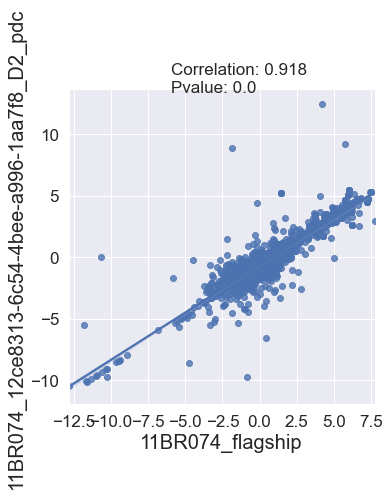

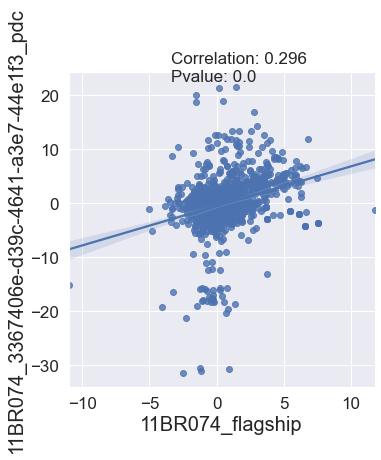

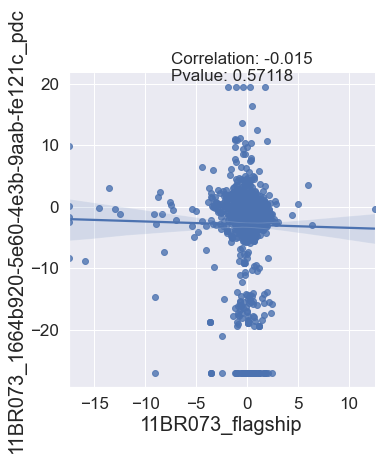

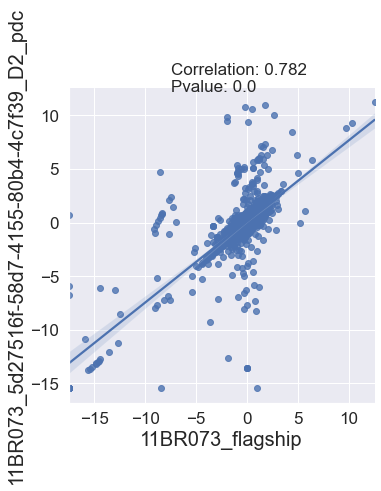

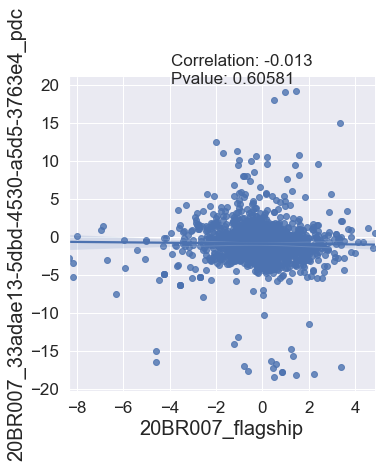

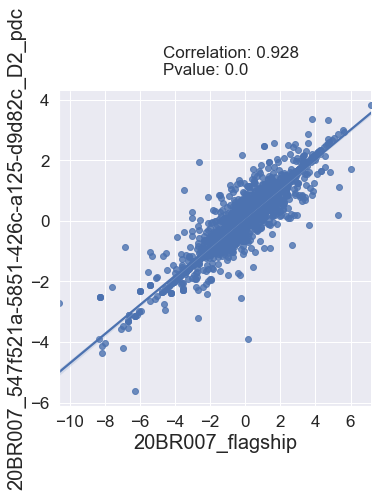

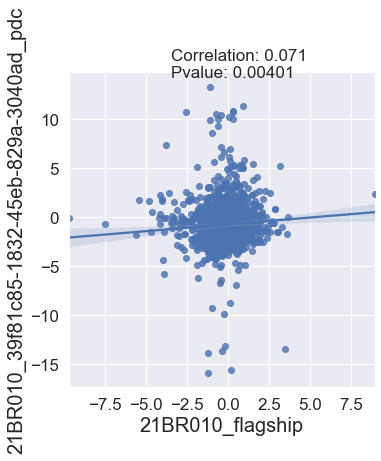

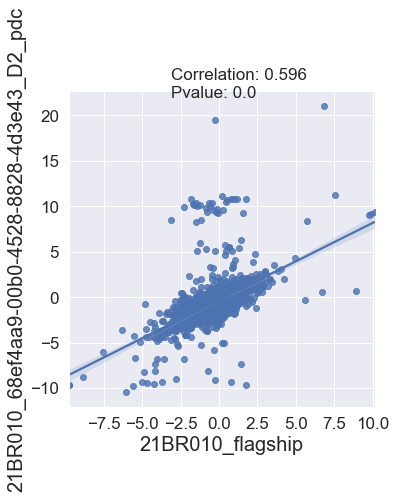

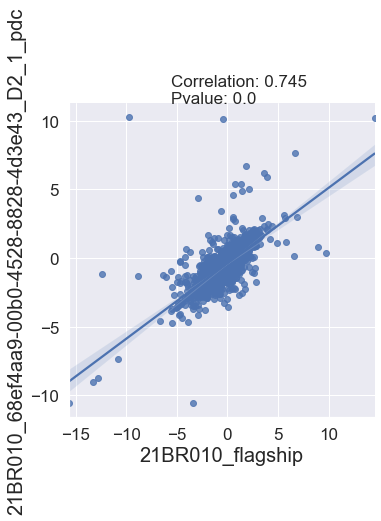

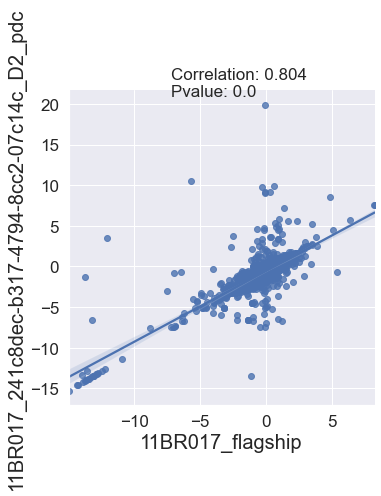

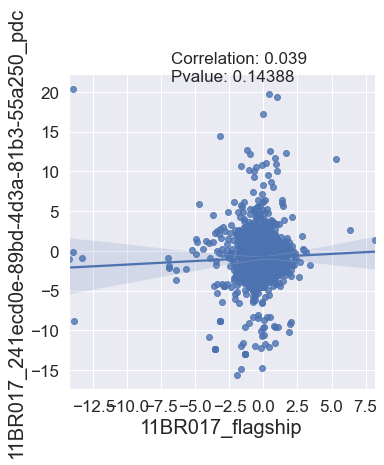

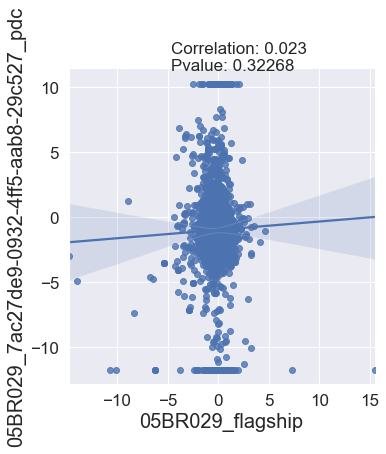

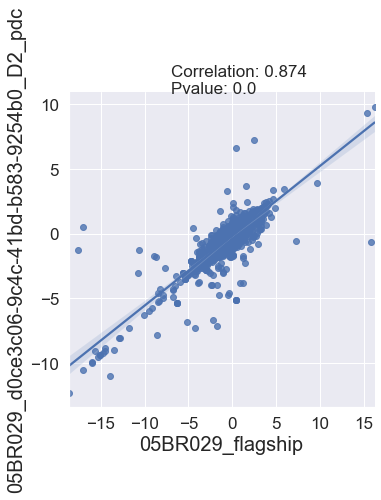

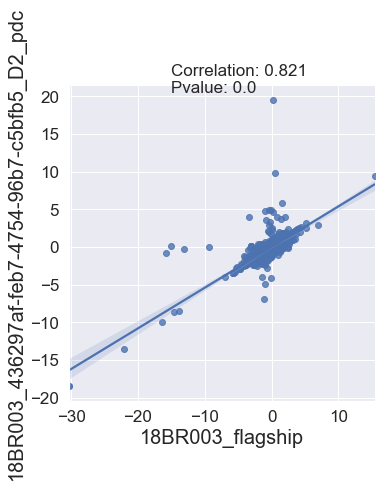

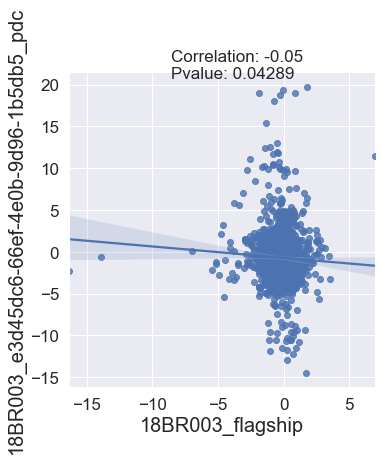

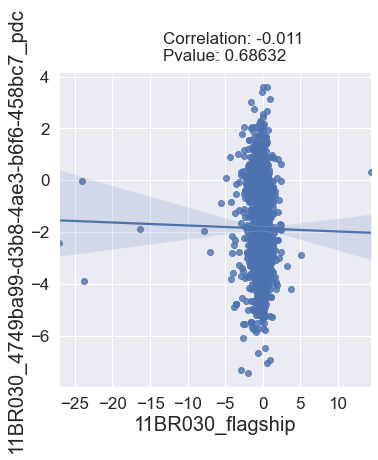

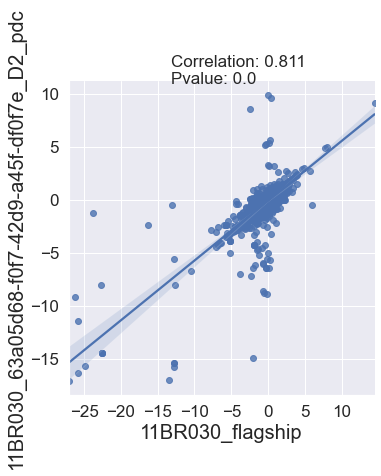

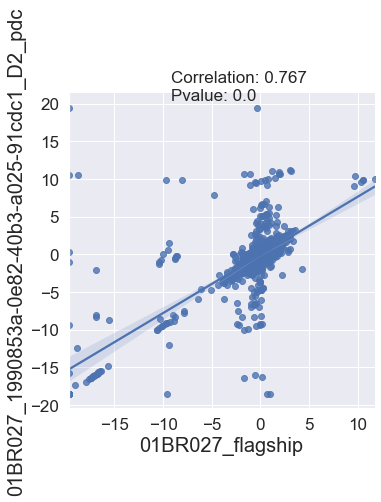

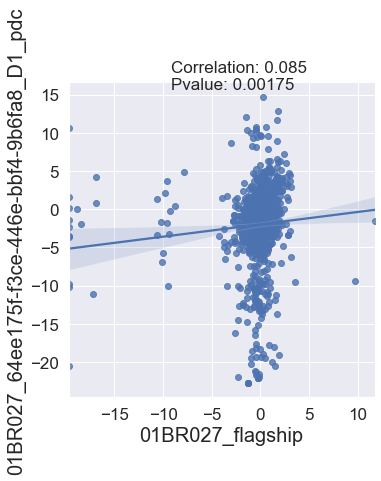

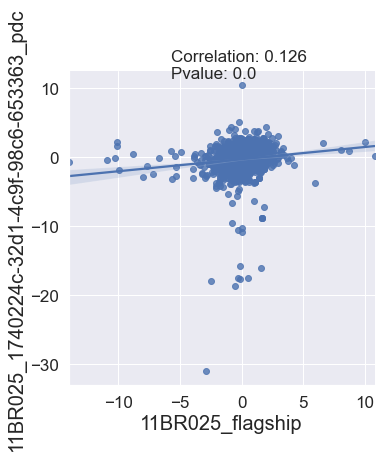

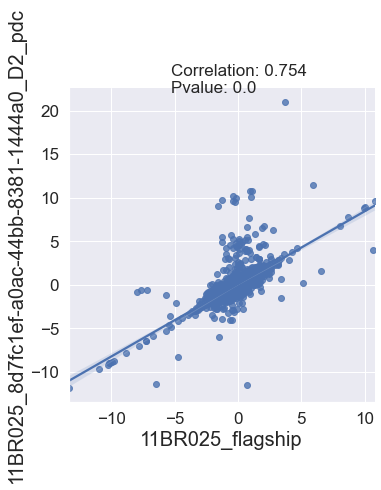

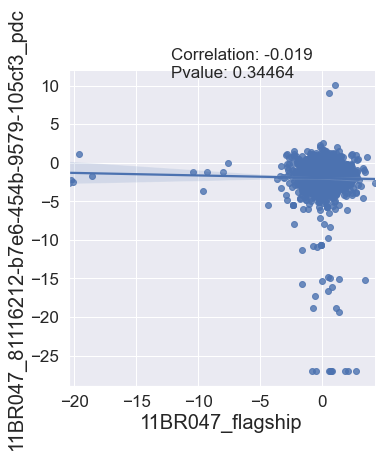

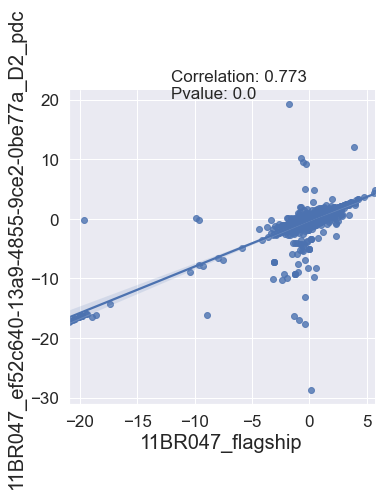

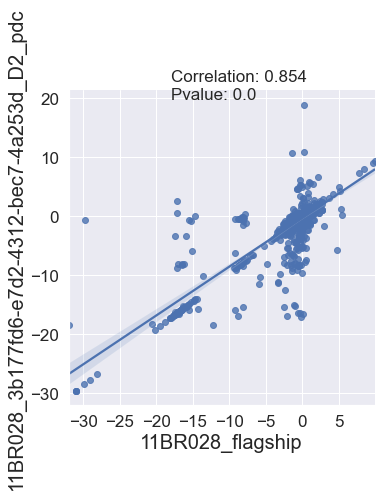

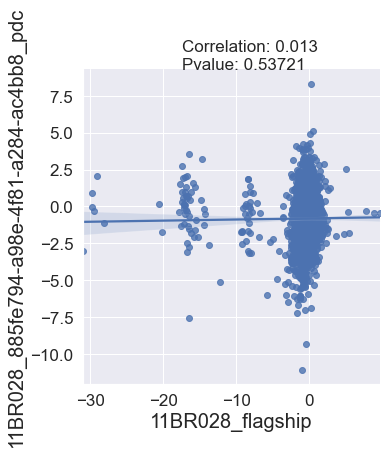

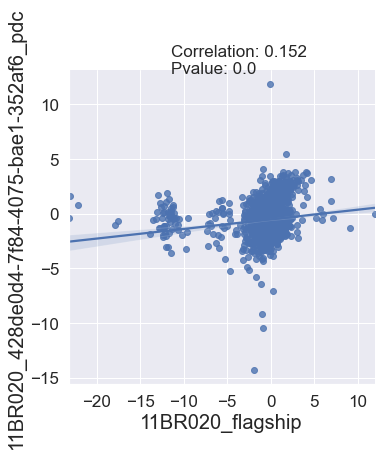

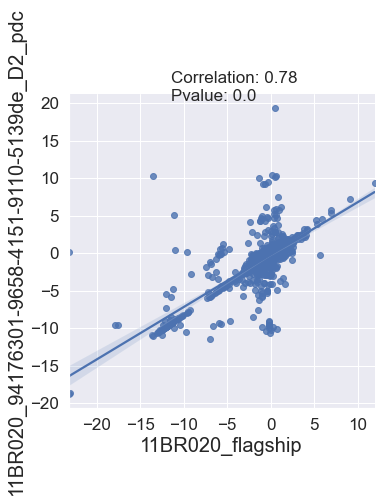

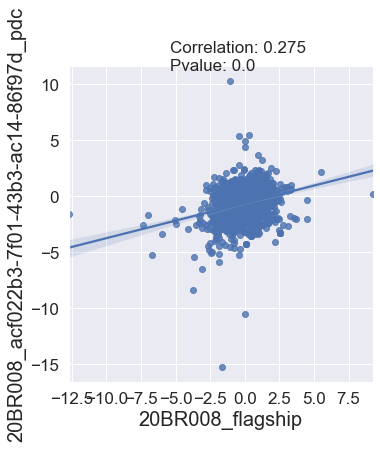

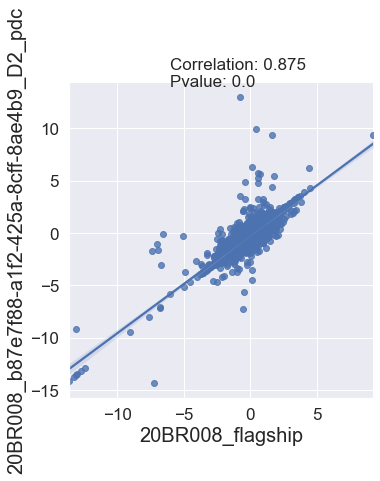

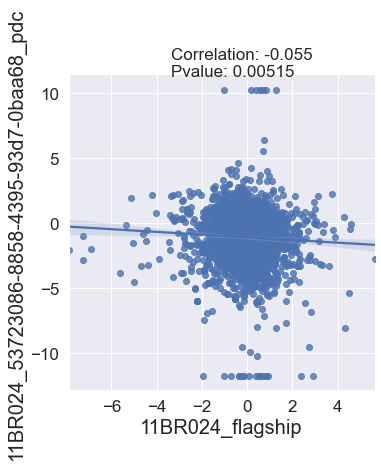

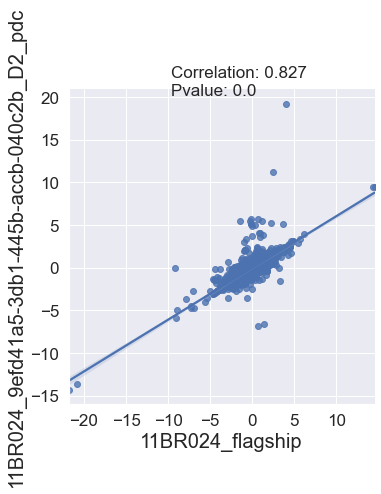

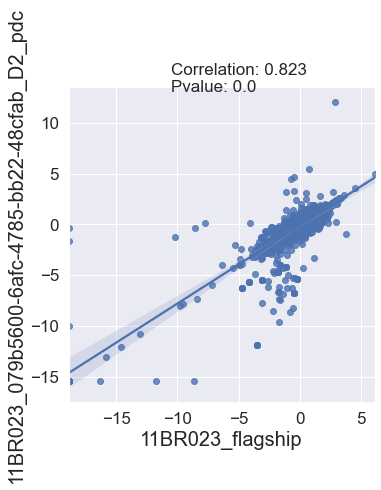

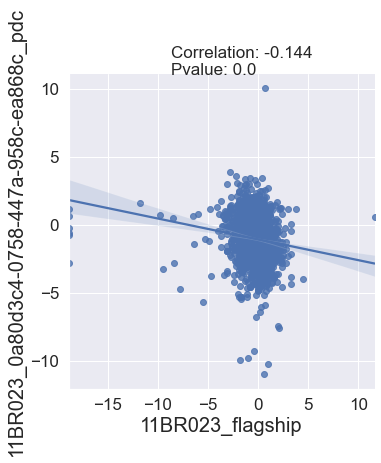

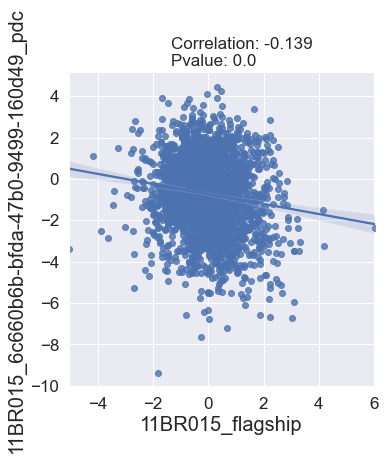

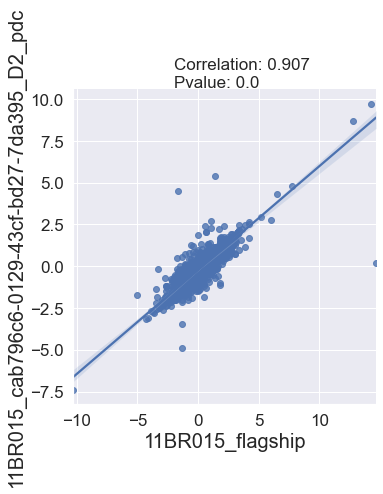

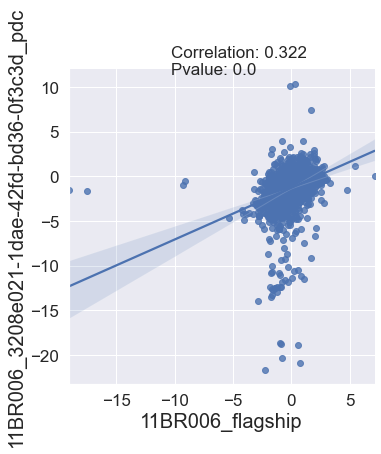

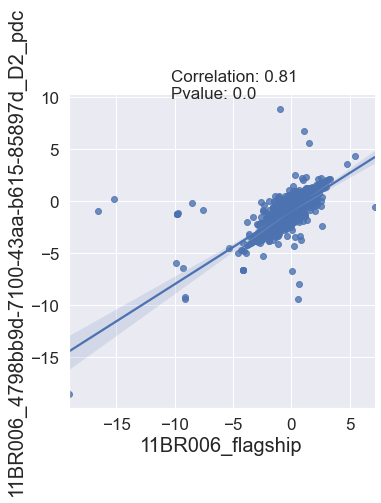

In [17]:
wrap_lin_reg(both, norm, y_lab = source_name)

In [18]:
print(omics)
get_corr(both, norm)

,Comparison,Correlation,P_value
0,11BR074_12ce8313-6c54-4bee-a996-1aa7f8_D2,0.918217,0.000000e+00
0,11BR074_3367406e-d39c-4641-a3e7-44e1f3,0.296427,1.874940e-33
0,11BR073_1664b920-5e60-4e3b-9aab-fe121c,-0.015403,5.711866e-01
0,11BR073_5d27516f-58d7-4155-80b4-4c7f39_D2,0.782197,0.000000e+00
0,20BR007_33adae13-5dbd-4530-a5d5-3763e4,-0.013545,6.058172e-01
0,20BR007_547f521a-5851-426c-a125-d9d82c_D2,0.928009,0.000000e+00
0,21BR010_39f81c85-1832-45eb-829a-3040ad,0.071541,4.010234e-03
0,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2,0.596018,0.000000e+00
0,21BR010_68ef4aa9-00b0-4528-8828-4d3e43_D2_1,0.745220,0.000000e+00
0,11BR017_241c8dec-b317-4794-8cc2-07c14c_D2,0.804362,0.000000e+00


# Hnscc

Check correlation of replicates with each other (confirmed same tissue type).

In [19]:
h = pc.PancanHnscc()
hnscc = cptac.Hnscc()

In [23]:
# show which omics has duplicates
ca = h
source_name = 'pdc'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
#acetyl = ca.get_acetylproteomics(source_name) # not included in pdchnscc
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(set(phos.index[phos.index.duplicated()])))
#print('acetyl:', set(acetyl.index.duplicated()))

prot: {False} []
phospho: {False, True} ['C3L-02617', 'C3L-02617.N', 'C3L-00994.N']


In [24]:
# Keep aliquots
df = h.get_phosphoproteomics('pdc')
df = df.reset_index()
df = df.loc[df.Patient_ID.duplicated(keep = False)]
df = ut.reduce_multiindex(df, levels_to_drop = [1], flatten=True)
df = df.loc[:,~df.columns.duplicated()] # drop all duplicate prot or sites (dup once database ID dropped)
df.index = df.Patient_ID+'_'+df.aliquot_submitter_id # uncomment code that dropped aliquot in pancan to use
df = df.T
df = df.drop(['aliquot_submitter_id', 'Patient_ID','case_submitter_id'])
pcdf = rename_duplicate_cols(df)
pcdf.index = pcdf.index.str.upper()
pcdf

cptac warning: Due to dropping the specified levels, dataframe now has 1983 duplicated column headers. (<ipython-input-24-700f5a72ff91>, line 5)


,C3L-02617_CPT0229210003,C3L-02617_CPT0229190003,C3L-02617_CPT0229190003_1,C3L-00994.N_CPT0169750003,C3L-00994.N_CPT0169750003_1,C3L-02617.N_CPT0229230003,C3L-02617.N_CPT0229230003_1
Name,,,,,,,
A2M_Y708,0.588766,NaN,NaN,NaN,NaN,NaN,-0.275456
A2ML1_S658,NaN,-1.922906,-0.459314,2.40123,1.874197,-0.808742,NaN
A2ML1_T824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS_S462,-0.004294,0.731831,0.869185,-1.475864,-0.896655,0.281972,0.121732
AAK1_S14,1.491017,NaN,NaN,NaN,NaN,NaN,0.550654
...,...,...,...,...,...,...,...
ZZZ3_S113,1.284931,0.854123,0.95669,-0.670861,-1.119188,-0.553187,-0.748802
ZZZ3_S130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZZ3_S131,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C3L-02617


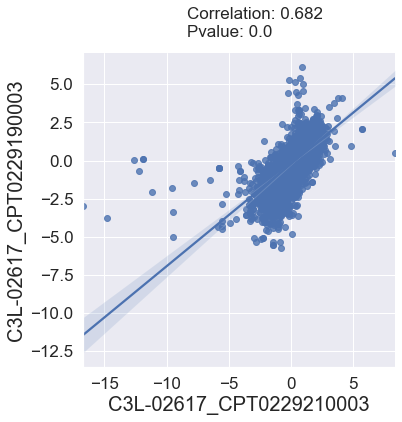

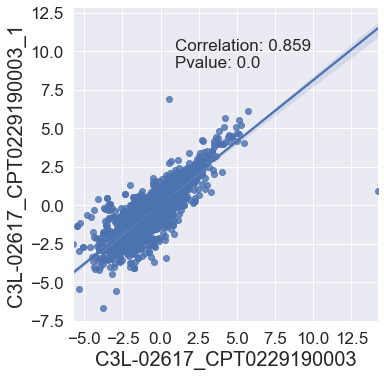

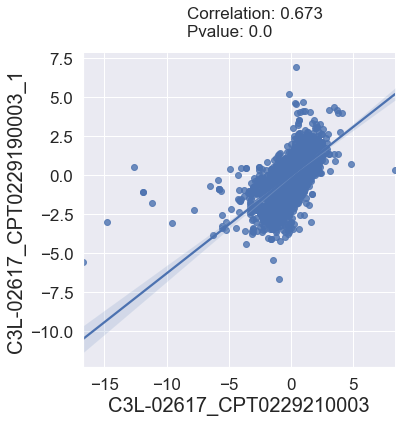

C3L-00994.N


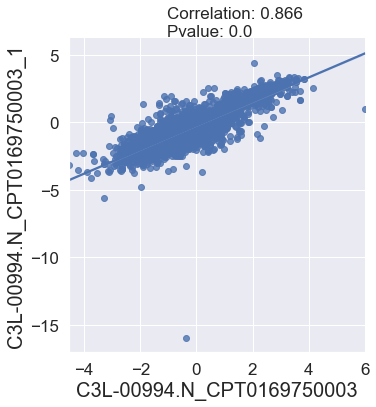

C3L-02617.N


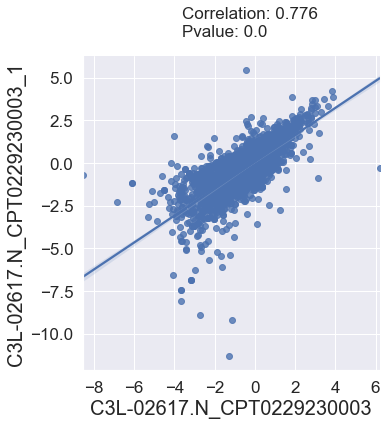

In [25]:
# compare correlations between pancan duplicates

df = pcdf
for col in df.columns:
    df[col] = pd.to_numeric(df[col])  

dup_list = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N'] 

for i in dup_list:
    if '.N' in i:
        dups = df.columns[df.columns.str.contains(i)].to_list()
    else:
        dups = df.columns[df.columns.str.contains(i) & ~ df.columns.str.contains('\.N')].to_list()
    
    print(i)
    first = dups[0]
    second = dups[1]
    
    plot_df = df[[first, second]].dropna()
    xd = plot_df[first].min() + ((plot_df[first].max() - plot_df[first].min()) / 3) 
    yd = plot_df[second].max() + 2

    p.plot_pearson(plot_df, first, second, x_coor = xd, y_coor = yd, 
           hue = "none", title = "", ra_stats = True,
           show_plot = True)
        
    if len(dups) == 3:
        third = dups[2]
        plot_df2 = df[[second, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df2[second].min() + ((plot_df2[second].max() - plot_df2[second].min()) / 3)
        yd = plot_df2[third].max() + 2                       
        p.plot_pearson(plot_df2, second, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)
        
        plot_df3 = df[[first, third]].dropna(axis = 'index', how = 'any')
        xd = plot_df3[first].min() + ((plot_df3[first].max() - plot_df3[first].min()) / 3)
        yd = plot_df3[third].max() + 2
        p.plot_pearson(plot_df3, first, third, x_coor = xd, y_coor = yd,
               hue = "none", title = "", ra_stats = True,
               show_plot = True)

In [26]:
# Flagship
hnscc_dup = ['C3L-02617', 'C3L-00994.N', 'C3L-02617.N']
fdf = get_flag_df('phospho', hnscc, hnscc_dup)
fdf

cptac warning: Due to dropping the specified levels, dataframe now has 6904 duplicated column headers. (<ipython-input-5-b2b0f2ee8e36>, line 20)


Patient_ID,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship
Name,,,
A2M_S710,NaN,NaN,15.412727
A2M_S928,NaN,NaN,NaN
A2ML1_S658,NaN,NaN,NaN
A2ML1_S698,NaN,NaN,NaN
AAAS_S462,24.627331,23.12606,23.729201
...,...,...,...
ZZZ3_S381T388,NaN,NaN,NaN
ZZZ3_S391,22.452369,20.65330,20.989371
ZZZ3_S396,NaN,NaN,NaN


In [27]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

,C3L-02617_flagship,C3L-00994.N_flagship,C3L-02617.N_flagship,C3L-02617_CPT0229210003,C3L-02617_CPT0229190003,C3L-02617_CPT0229190003_1,C3L-00994.N_CPT0169750003,C3L-00994.N_CPT0169750003_1,C3L-02617.N_CPT0229230003,C3L-02617.N_CPT0229230003_1
Name,,,,,,,,,,
A2ML1_S658,NaN,NaN,NaN,NaN,-1.922906,-0.459314,2.401230,1.874197,-0.808742,NaN
AAAS_S462,24.627331,23.126060,23.729201,-0.004294,0.731831,0.869185,-1.475864,-0.896655,0.281972,0.121732
AAK1_S20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAK1_S21,21.263338,21.221686,21.079183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAK1_S624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
ZZEF1_S1537S1540,20.352143,NaN,NaN,NaN,0.103903,NaN,NaN,NaN,NaN,NaN
ZZEF1_S1540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZEF1_S1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

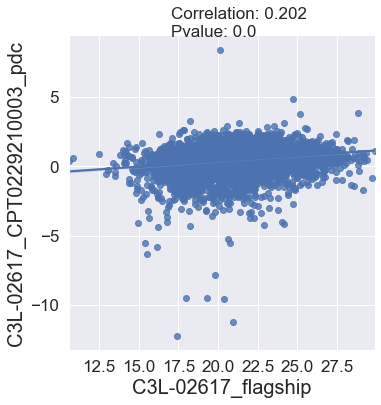

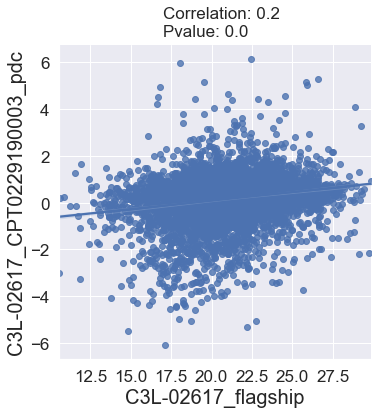

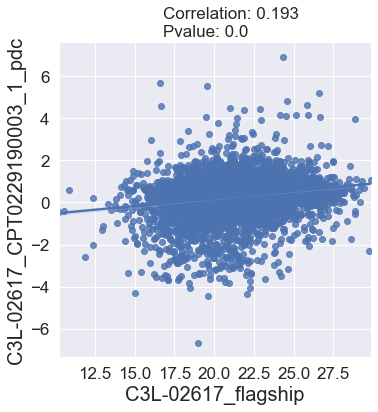

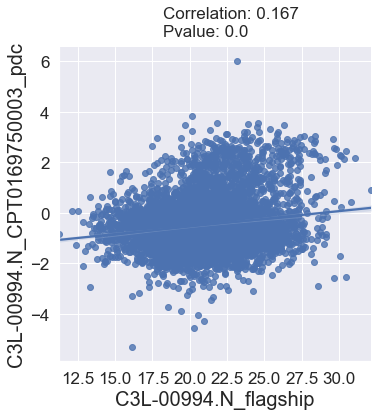

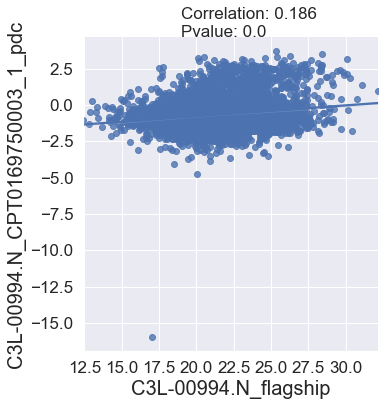

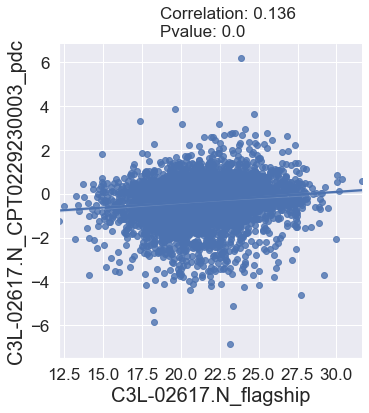

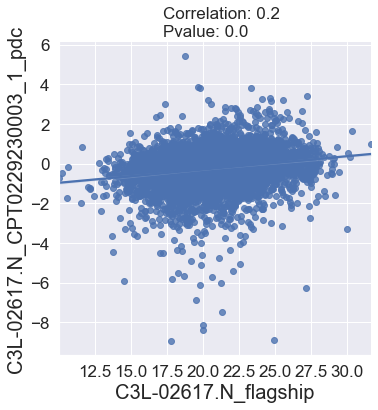

In [29]:
# compare to flagship - doesn't correlate well
wrap_lin_reg(both, hnscc_dup, y_lab = source_name)

# Luad

In [30]:
l = pc.PancanLuad()
luad = cptac.Luad()

In [ ]:
# show which omics has duplicates
ca = l
source_name = 'pdc'
#source_name = 'umich'
prot = ca.get_proteomics(source_name)
phos = ca.get_phosphoproteomics(source_name)
acetyl = ca.get_acetylproteomics(source_name)
print('prot:', set(prot.index.duplicated()), list(prot.index[prot.index.duplicated()]))
print('phospho:', set(phos.index.duplicated()), list(phos.index[phos.index.duplicated()]))
print('acetyl:', set(acetyl.index.duplicated()), list(acetyl.index[acetyl.index.duplicated()]))

In [ ]:
#omics = 'phospho'
omics = 'acetyl'
dup_list = ['C3N-02379', 'C3N-02587']
pcdf = get_pc_df(omics, l, 'pdc', dup_list)
pcdf

In [ ]:
dup_list = ['C3N-02379', 'C3N-02587']
fdf = get_flag_df(omics, luad, dup_list)
fdf

In [ ]:
both = fdf.join(pcdf, how = 'inner')
both.head()
both

for col in both.columns:
    both[col] = pd.to_numeric(both[col])  

wrap_lin_reg(both, dup_list, y_lab = source_name)